In [44]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click to Open/Close the Code."></form>''')

### Libraries

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from HDSIdent.data_treatment.data_preprocessing import Preprocessing
from HDSIdent.initial_intervals.bandpass_filter import BandpassFilter

import plotly.io as pio
from plotly.offline import plot, iplot, init_notebook_mode
pio.renderers.default='notebook'
init_notebook_mode(connected=True)

%matplotlib inline
sns.set_style('darkgrid')

### Read Data

#### NOTICE: this simulation data here presented was produced inspired in Exemple 3 of the following work:

<cite>WANG, J. et al. Searching historical data segments for process identification in feedback control loops. Computers and Chemical Engineering, v. 112, n. 6, p. 6–16, 2018.</cite>

In [3]:
u_url = 'https://github.com/GiulioCMSanto/HDSIdent/blob/master/data/water_tank/siso_simu_mv.csv'
sp_url = 'https://github.com/GiulioCMSanto/HDSIdent/blob/master/data/water_tank/siso_simu_sp.csv'
y_url = 'https://github.com/GiulioCMSanto/HDSIdent/blob/master/data/water_tank/siso_simu_y.csv'

In [5]:
!ls

bandpass_filter.ipynb               pettitt_change_point.ipynb
exponentially_weighted_filter.ipynb sliding_window.ipynb


In [20]:
mv = pd.read_csv('../../../data/water_tank/siso_simu_mv.csv', error_bad_lines=False, header=None)
sp = pd.read_csv('../../../data/water_tank/siso_simu_sp.csv', error_bad_lines=False, header=None)
y = pd.read_csv('../../../data/water_tank/siso_simu_y.csv', error_bad_lines=False, header=None)

### Data Pre-processing

In [21]:
pp = Preprocessing(
        scaler='MinMaxScaler',
        feature_range=(-0.5,0.5),
        k=100);

In [22]:
X_clean, Y_clean = pp.fit_transform(X=np.concatenate([mv,sp],axis=1),
                                    y=y)

In [23]:
df = pd.DataFrame()
df['MV'] = X_clean[:,0]
df['SP'] = X_clean[:,1]
df['Y'] = Y_clean

In [24]:
df.head()

,MV,SP,Y
0,0.003182,-0.1,-0.109338
1,-0.000913,-0.1,-0.106037
2,-0.009513,-0.1,-0.099186
3,-0.012116,-0.1,-0.097125
4,-0.008668,-0.1,-0.099873


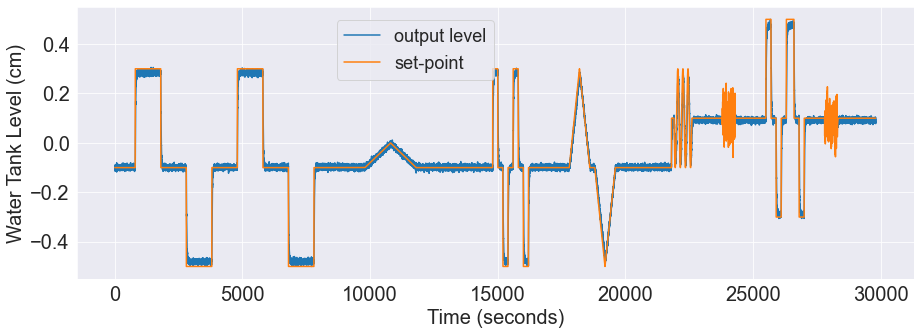

In [25]:
plt.figure(figsize=(15,5))
plt.plot(Y_clean,label="output level");
plt.plot(X_clean[:,1],label="set-point");
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
plt.ylabel("Water Tank Level (cm)", fontsize=20);
plt.xlabel("Time (seconds)", fontsize=20);
plt.legend(fontsize=18,bbox_to_anchor=(0.3,0.7));

### Bandpass Potential Intervals

#### Method Reference:

<cite>PATEL, A. Data Mining of Process Data in Mutlivariable Systems. Degree project in electrical engineering — Royal Institute of Technology, Stockholm, Sweden, 2016.</cite>

In [26]:
BP = BandpassFilter(
       W=[0.006, 0.04],
       H=[0.02]*3,
       N=1
    )

In [29]:
start = time()
BP.fit(X=df[['MV','SP']],y=df[['Y']]);
end = time()

In [30]:
print("Execution Time: {}".format(end-start))

Execution Time: 1.2222609519958496


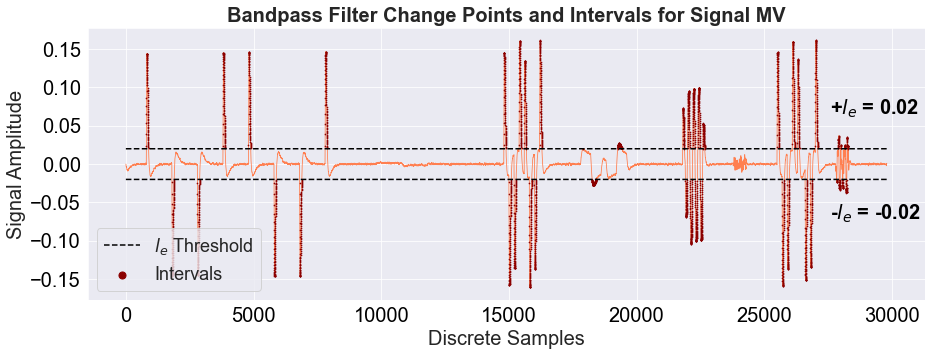

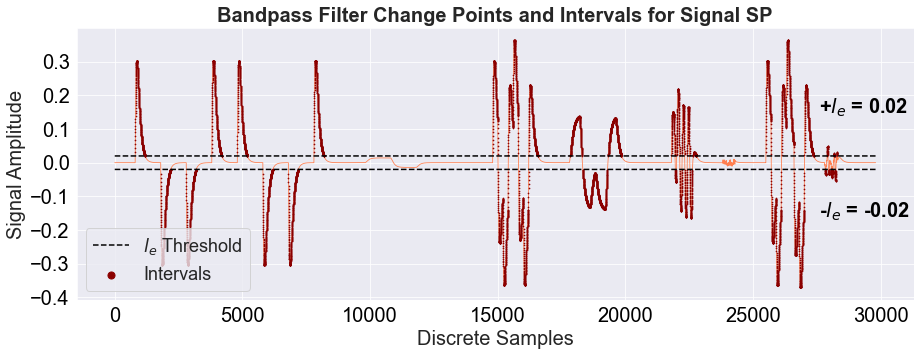

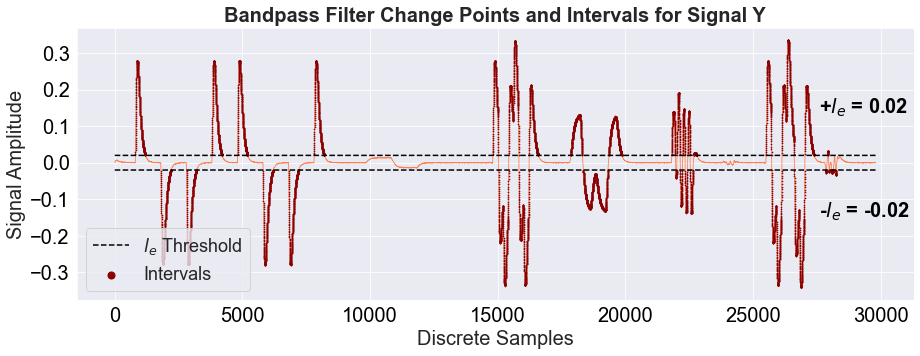

In [32]:
BP.plot_change_points(X=df[['MV','SP']],y=df[['Y']],threshold_name=r'$l_{e}$')

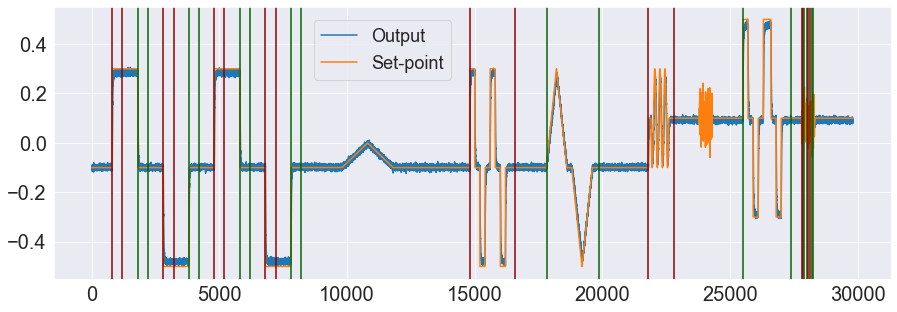

In [33]:
plt.figure(figsize=(15,5))
plt.plot(Y_clean, label="Output");
plt.plot(X_clean[:,1], label = "Set-point");
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);

counter = 2;
for key, interval in BP.unified_intervals.items():
    if counter%2==0:
        color = 'darkred'
    else:
        color = 'darkgreen'
        
    plt.axvline(np.min(interval),color=color);
    plt.axvline(np.max(interval),color=color);
    
    counter+=1

plt.legend(fontsize=18,bbox_to_anchor=(0.3,0.7));

### Heatmap Analysis

In [37]:
W1 = [0.0001, 0.0002, 0.0004, 0.0006, 0.0008, 0.001, 0.0012, 0.0014, 0.0015]
W2 = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

W1_grid, W2_grid = np.meshgrid(W1, W2)
num_intervals_mtx = np.zeros((W1_grid.shape[0],W1_grid.shape[1]))
len_intervals_mtx = np.zeros((W1_grid.shape[0],W1_grid.shape[1]))

counter = 0
for idx_1 in range(W1_grid.shape[0]):
    for idx_2 in range(W1_grid.shape[1]):
        
        counter+=1
        
        if counter%4==0:
            print("Iteration {}/{}".format(counter,W1_grid.shape[0]*W1_grid.shape[1]))
    
        W1 = W1_grid[idx_1,idx_2]
        W2 = W2_grid[idx_1,idx_2]
        

        BP = BandpassFilter(
               W=[W1, W2],
               H=[0.02]*3,
               N=1
            ) 
        
        intervals = BP.fit(X=df[['SP']],y=df[['Y']]);

        num_intervals_mtx[idx_1,idx_2] = len(intervals.keys())
        
        len_arr = []
        for key, value in intervals.items():
            len_arr.append(len(value))
            
        len_intervals_mtx[idx_1,idx_2] = np.mean(len_arr)
        
len_intervals_mtx = np.nan_to_num(len_intervals_mtx,0)

Iteration 4/135
Iteration 8/135
Iteration 12/135
Iteration 16/135
Iteration 20/135
Iteration 24/135
Iteration 28/135
Iteration 32/135
Iteration 36/135
Iteration 40/135
Iteration 44/135
Iteration 48/135
Iteration 52/135
Iteration 56/135
Iteration 60/135
Iteration 64/135
Iteration 68/135
Iteration 72/135
Iteration 76/135
Iteration 80/135
Iteration 84/135
Iteration 88/135
Iteration 92/135
Iteration 96/135
Iteration 100/135
Iteration 104/135
Iteration 108/135
Iteration 112/135
Iteration 116/135
Iteration 120/135
Iteration 124/135
Iteration 128/135
Iteration 132/135


In [38]:
import plotly.graph_objects as go
W1 = [0.0001, 0.0002, 0.0004, 0.0006, 0.0008, 0.001, 0.0012, 0.0014, 0.0015]
W2 = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

fig = go.Figure(data =
    go.Contour(
        z=num_intervals_mtx,
        x=W1, # horizontal axis
        y=W2, # vertical axis,
        zmin=0,
        zmax=40,
        colorscale='bugn',
                contours=dict(
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 26,
                color = 'black',
            )
    )))

fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    title={'y':0.9,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    xaxis_title=r"$\Large \text{Frequency } w_{1} \text{ (Rad/s)}$",
    yaxis_title=r"$\Large \text{Frequency } w_{2} \text{ (Rad/s)}$",
    font=dict(
        family="Times New Roman",
        size=22,
        color="black"
    ),
)

fig.show()

In [39]:
import plotly.graph_objects as go
W1 = [0.0001, 0.0002, 0.0004, 0.0006, 0.0008, 0.001, 0.0012, 0.0014, 0.0015]
W2 = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

fig = go.Figure(data =
    go.Contour(
        z=len_intervals_mtx,
        x=W1, # horizontal axis
        y=W2, # vertical axis,
        zmin=0,
        zmax=3000,
        colorscale='bugn',
                contours=dict(
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 26,
                color = 'black',
            )
    )))

fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    title={'y':0.9,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    xaxis_title=r"$\Large \text{Frequency } w_{1} \text{ (Rad/s)}$",
    yaxis_title=r"$\Large \text{Frequency } w_{2} \text{ (Rad/s)}$",
    font=dict(
        family="Times New Roman",
        size=22,
        color="black"
    ),
)

fig.show()

In [17]:
W1 = [0.0001, 0.0002, 0.0004, 0.0006, 0.0008, 0.001, 0.0012, 0.0014, 0.0015]
W2 = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

W1_grid, W2_grid = np.meshgrid(W1, W2)
num_intervals_mtx = np.zeros((W1_grid.shape[0],W1_grid.shape[1]))
len_intervals_mtx = np.zeros((W1_grid.shape[0],W1_grid.shape[1]))

counter = 0
for idx_1 in range(W1_grid.shape[0]):
    for idx_2 in range(W1_grid.shape[1]):
        
        counter+=1
        
        if counter%4==0:
            print("Iteration {}/{}".format(counter,W1_grid.shape[0]*W1_grid.shape[1]))
    
        W1 = W1_grid[idx_1,idx_2]
        W2 = W2_grid[idx_1,idx_2]
        

        BP = BandpassFilter(
               W=[W1, W2],
               H=[0.005]*3,
               N=1
            ) 
        
        intervals = BP.fit(X=df[['SP']],y=df[['Y']]);

        num_intervals_mtx[idx_1,idx_2] = len(intervals.keys())
        
        len_arr = []
        for key, value in intervals.items():
            len_arr.append(len(value))
            
        len_intervals_mtx[idx_1,idx_2] = np.mean(len_arr)
        
len_intervals_mtx = np.nan_to_num(len_intervals_mtx,0)

Iteration 4/135
Iteration 8/135
Iteration 12/135
Iteration 16/135
Iteration 20/135
Iteration 24/135
Iteration 28/135
Iteration 32/135
Iteration 36/135
Iteration 40/135
Iteration 44/135
Iteration 48/135
Iteration 52/135
Iteration 56/135
Iteration 60/135
Iteration 64/135
Iteration 68/135
Iteration 72/135
Iteration 76/135
Iteration 80/135
Iteration 84/135
Iteration 88/135
Iteration 92/135
Iteration 96/135
Iteration 100/135
Iteration 104/135
Iteration 108/135
Iteration 112/135
Iteration 116/135
Iteration 120/135
Iteration 124/135
Iteration 128/135
Iteration 132/135


In [18]:
import plotly.graph_objects as go
W1 = [0.0001, 0.0002, 0.0004, 0.0006, 0.0008, 0.001, 0.0012, 0.0014, 0.0015]
W2 = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

fig = go.Figure(data =
    go.Contour(
        z=num_intervals_mtx,
        x=W1, # horizontal axis
        y=W2, # vertical axis,
        zmin=0,
        zmax=40,
        colorscale='bugn',
                contours=dict(
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 26,
                color = 'black',
            )
    )))

fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    title={'y':0.9,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    xaxis_title=r"$\Large \text{Frequency } w_{1} \text{ (Rad/s)}$",
    yaxis_title=r"$\Large \text{Frequency } w_{2} \text{ (Rad/s)}$",
    font=dict(
        family="Times New Roman",
        size=22,
        color="black"
    ),
)

fig.show()

In [19]:
import plotly.graph_objects as go
W1 = [0.0001, 0.0002, 0.0004, 0.0006, 0.0008, 0.001, 0.0012, 0.0014, 0.0015]
W2 = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

fig = go.Figure(data =
    go.Contour(
        z=len_intervals_mtx,
        x=W1, # horizontal axis
        y=W2, # vertical axis,
        zmin=0,
        zmax=6000,
        colorscale='bugn',
                contours=dict(
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 26,
                color = 'black',
            )
    )))

fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    title={'y':0.9,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    xaxis_title=r"$\Large \text{Frequency } w_{1} \text{ (Rad/s)}$",
    yaxis_title=r"$\Large \text{Frequency } w_{2} \text{ (Rad/s)}$",
    font=dict(
        family="Times New Roman",
        size=22,
        color="black"
    ),
)

fig.show()

In [20]:
W1 = [0.0001, 0.0002, 0.0004, 0.0006, 0.0008, 0.001, 0.0012, 0.0014, 0.0015]
W2 = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

W1_grid, W2_grid = np.meshgrid(W1, W2)
num_intervals_mtx = np.zeros((W1_grid.shape[0],W1_grid.shape[1]))
len_intervals_mtx = np.zeros((W1_grid.shape[0],W1_grid.shape[1]))

counter = 0
for idx_1 in range(W1_grid.shape[0]):
    for idx_2 in range(W1_grid.shape[1]):
        
        counter+=1
        
        if counter%4==0:
            print("Iteration {}/{}".format(counter,W1_grid.shape[0]*W1_grid.shape[1]))
    
        W1 = W1_grid[idx_1,idx_2]
        W2 = W2_grid[idx_1,idx_2]
        

        BP = BandpassFilter(
               W=[W1, W2],
               H=[0.1]*3,
               N=1
            ) 
        
        intervals = BP.fit(X=df[['SP']],y=df[['Y']]);

        num_intervals_mtx[idx_1,idx_2] = len(intervals.keys())
        
        len_arr = []
        for key, value in intervals.items():
            len_arr.append(len(value))
            
        len_intervals_mtx[idx_1,idx_2] = np.mean(len_arr)
        
len_intervals_mtx = np.nan_to_num(len_intervals_mtx,0)

Iteration 4/135
Iteration 8/135
Iteration 12/135
Iteration 16/135
Iteration 20/135
Iteration 24/135
Iteration 28/135
Iteration 32/135
Iteration 36/135
Iteration 40/135
Iteration 44/135
Iteration 48/135
Iteration 52/135
Iteration 56/135
Iteration 60/135
Iteration 64/135
Iteration 68/135
Iteration 72/135
Iteration 76/135
Iteration 80/135
Iteration 84/135
Iteration 88/135
Iteration 92/135
Iteration 96/135
Iteration 100/135
Iteration 104/135
Iteration 108/135
Iteration 112/135
Iteration 116/135
Iteration 120/135
Iteration 124/135
Iteration 128/135
Iteration 132/135


In [21]:
import plotly.graph_objects as go
W1 = [0.0001, 0.0002, 0.0004, 0.0006, 0.0008, 0.001, 0.0012, 0.0014, 0.0015]
W2 = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

fig = go.Figure(data =
    go.Contour(
        z=num_intervals_mtx,
        x=W1, # horizontal axis
        y=W2, # vertical axis,
        zmin=0,
        zmax=45,
        colorscale='bugn',
                contours=dict(
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 26,
                color = 'black',
            )
    )))

fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    title={'y':0.9,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    xaxis_title=r"$\Large \text{Frequency } w_{1} \text{ (Rad/s)}$",
    yaxis_title=r"$\Large \text{Frequency } w_{2} \text{ (Rad/s)}$",
    font=dict(
        family="Times New Roman",
        size=22,
        color="black"
    ),
)

fig.show()

In [22]:
import plotly.graph_objects as go
W1 = [0.0001, 0.0002, 0.0004, 0.0006, 0.0008, 0.001, 0.0012, 0.0014, 0.0015]
W2 = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

fig = go.Figure(data =
    go.Contour(
        z=len_intervals_mtx,
        x=W1, # horizontal axis
        y=W2, # vertical axis,
        zmin=0,
        zmax=4000,
        colorscale='bugn',
                contours=dict(
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 26,
                color = 'black',
            )
    )))

fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    title={'y':0.9,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    xaxis_title=r"$\Large \text{Frequency } w_{1} \text{ (Rad/s)}$",
    yaxis_title=r"$\Large \text{Frequency } w_{2} \text{ (Rad/s)}$",
    font=dict(
        family="Times New Roman",
        size=22,
        color="black"
    ),
)

fig.show()

### Impact on Step Responses

(780, 820)

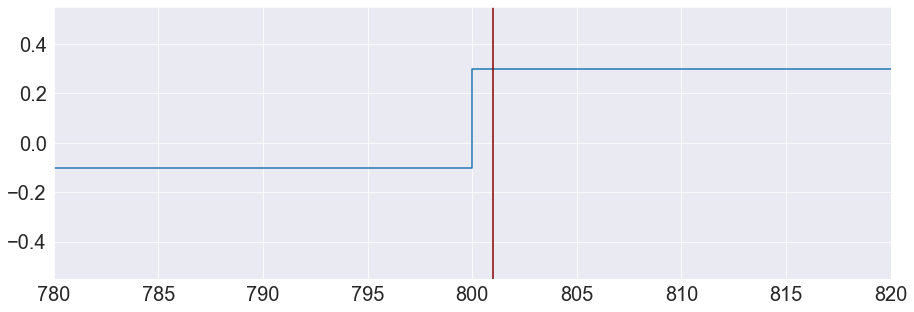

In [39]:
plt.figure(figsize=(15,5))
plt.step(range(0,len(X_clean[:,1])),X_clean[:,1], label = "Set-point");
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);

counter = 2;
for key, interval in BP.unified_intervals.items():
    if counter%2==0:
        color = 'darkred'
    else:
        color = 'darkgreen'
        
    plt.axvline(np.min(interval),color=color);
    plt.axvline(np.max(interval),color=color);
    
    counter+=1

plt.xlim([780,820])